<a href="https://colab.research.google.com/github/constructor-s/aps1080_winter_2021/blob/main/A4/A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A4: Fapprox and SARSA control
=============================
> 
> Start Assignment
> 
> *   Due Friday by 11:59pm
> *   Points 10
> *   Submitting a file upload
> 
> You will use function approximation to devise controllers for the mountain car and/or cart pole problems. You may **chose** which of the two you wish to attempt, and will use the fapprox techniques you explored in Exercise IV for this assignment.
> 
> The goal is to employ the SARSA(n) (n>=0) fapprox techniques of C10 to control the environment of choice.
> 
> There are a variety of solutions that have been posted on the internet; most of these use offline training, in contrast to what the textbook shows. The textbook is showing the more appropriate solution technique and you must use that. You may use the internet-based solutions as a guide on how to set your neural network complexity (# layers, # neurons), however, you must use the 10.1 or 10.2 algorithms.
> 
> Exercise IV should have provided you a template for how to do this: you will use the stochastic gradient descent algorithm, where the reference ("training input") will come from the 10.1 or 10.2 algorithms.
> 
> Submit you code as solver.py and results.pdf that summarizes the results of your implementation (NN structure, algorithm selected, training characteristics, and performance.
> 
> Ref: Files/stochastic\_gradient\_descent\_example.py
> 
> 1618027199 04/09/2021 11:59pm

# Set up dependencies, functions

In [1]:
#%% Set up rendering

if False:
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=False, size=(400, 300))
    display.start()

In [2]:
#%% Imports

import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import datetime
import time


The function below generates episodes of experience of a provided environment (`CartPole` or `MountainCar`) - see doc string for details. And at the output we test this function by generating an episode and print it out.

In [3]:
#%% Set up the environment
def run_env(policy_fun, 
            env, max_iter=1000, 
            debug=False, plot=False):
    """
    Simulate episodes of the environment

    Parameters
    ------------------
    policy_fun : function
        A function that maps observation, and current time step index 
        to valid action
    
    debug : bool
        print the last two states

    plot : bool
        plot visualization during select steps
        a (virtual) screen must be available for gym render

    Yields
    ------------------
    O_t, A_t, R_t+1, O_t+1, A_t+1, done
        SARSA pairs. O is the observation.
    """
    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(11, 8.5))

    obs = env.reset() 
    a = policy_fun(obs, 0)
    for i in range(max_iter):
        next_obs, r, done, info = env.step(a) 
        next_a = policy_fun(next_obs, i+1)
        yield obs, a, r, next_obs, next_a, done

        if plot and i%20 == 19:
            # Visualize some states
            ax.ravel()[i // 20].imshow(env.render(mode='rgb_array'))
            ax.ravel()[i // 20].set_title(
                f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
        if debug and done:
            print(f"Observation at i = {i}: {obs}")

        obs, a = next_obs, next_a

        if done:

            if debug:
                print(f"Observation at terminal: {obs}")
            if plot:
                ax.ravel()[-1].imshow(env.render(mode='rgb_array'))
                ax.ravel()[-1].set_title(
                    f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
                
            break
    env.close()

print("Generating a random episode:")
env = gym.make('MountainCar-v0') # gym.make('CartPole-v0')
pd.DataFrame(run_env(lambda *_, **__: env.action_space.sample(),
                     plot='display' in globals(), 
                     env=env),
             columns=["O_t", "A_t", "R_t+1", "O_t+1", "A_t+1", "done"])

Generating a random episode:


,O_t,A_t,R_t+1,O_t+1,A_t+1,done
0,"[-0.4196844268892397, 0.0]",2,-1.0,"[-0.419451222223059, 0.00023320466618072504]",0,False
1,"[-0.419451222223059, 0.00023320466618072504]",0,-1.0,"[-0.4209864774350995, -0.0015352552120405077]",0,False
2,"[-0.4209864774350995, -0.0015352552120405077]",0,-1.0,"[-0.4242792274630621, -0.0032927500279626657]",0,False
3,"[-0.4242792274630621, -0.0032927500279626657]",0,-1.0,"[-0.42930590101800864, -0.005026673554946513]",2,False
4,"[-0.42930590101800864, -0.005026673554946513]",2,-1.0,"[-0.4340303771148004, -0.004724476096791774]",0,False
...,...,...,...,...,...,...
195,"[-0.6416887128729333, 0.024768547751449876]",2,-1.0,"[-0.6150529010858485, 0.026635811787084695]",1,False
196,"[-0.6150529010858485, 0.026635811787084695]",1,-1.0,"[-0.5877397562566684, 0.027313144829180135]",1,False
197,"[-0.5877397562566684, 0.027313144829180135]",1,-1.0,"[-0.559948517233569, 0.027791239023099382]",1,False
198,"[-0.559948517233569, 0.027791239023099382]",1,-1.0,"[-0.5318851951538232, 0.028063322079745826]",2,False


# Training

In this section we will complete the textbook SARSA(n) algorithm by first setting up an MLP and then completing the rest of the algorithm.

## Set up Multi-Layer Perceptron

In [4]:
#%% Set up a differentiable action-value function parameterization
class Net(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=(256, 128)):
        super(Net, self).__init__()

        if len(hidden_size) == 1:
            self.mlp = nn.Sequential(
                nn.Linear(in_features, hidden_size[0]),
                nn.ReLU(),
                nn.Linear(hidden_size[0], out_features)
            )
        elif len(hidden_size) == 2:
            self.mlp = nn.Sequential(
                nn.Linear(in_features, hidden_size[0]),
                nn.ReLU(),
                nn.Linear(hidden_size[0], hidden_size[1]), 
                nn.ReLU(),
                nn.Linear(hidden_size[1], out_features)
            )
        else:
            raise RuntimeError()

    def forward(self, x):
        # Normalize x to approximately -1 to +1
        if env.spec.id == 'CartPole-v0':
            x = (x - (-2.3, -1.0, -0.20, -1.0)) / 2.0 / (+2.3, +1.0, +0.20, +1.0)
        else:
            x = (x - env.observation_space.low) / (
                env.observation_space.high - env.observation_space.low)
        # Convert to proper data type
        if type(x) == np.ndarray:
            x = torch.from_numpy(x).float()
        x = x.to(self.device)
        
        x = self.mlp(x)

        # Assume output is approximately -1 to +1, 
        # Normalize output to the scale of the return in the model
        x = x * 100
        
        return x
    
    @property
    def device(self):
        return next(self.parameters()).device


## n-step training algorithm as described on textbook

Here below we use n = 5

[181, 183, 185]
2021-04-09 00:22:06.936080


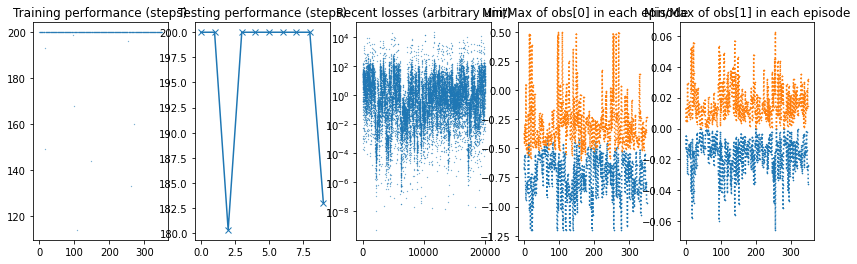

Good test performance - stop training
Training finished in 0:02:33.493325


In [5]:
env = env

# Initialize parameters
alpha = 1.0e-4
eps = 0.01
gamma = 0.9

# weights w handled by library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(env.observation_space.shape[0], env.action_space.n, 
          hidden_size=(4096, ))
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=alpha) # optim.SGD(net.parameters(), lr=alpha) # optim.SGD(net.parameters(), lr=alpha) # optim.Adam(net.parameters(), lr=alpha) # optim.SGD(net.parameters(), lr=alpha)
criterion = nn.MSELoss()

# TD n step
n = 5
rng = np.random.RandomState(0)

# Monitor training history
history_steps = []
history_steps_testing = []
history_loss = []
history_states = [[], []]
tic = datetime.datetime.now()
last_plot = time.time()
##

def policy_fun(obs, *args, **kwargs):
    """
    An eps greedy policy
    """
    if rng.random() < eps:
        # eps
        return env.action_space.sample()
    else:
        # Greedy
        with torch.no_grad():
            q_vals = net(obs)
        
        # Make sure q hasn't exploded
        assert q_vals.isfinite().all(), q_vals

        a = int(q_vals.argmax())
        return a

# Loop for each episode
for episode_i in range(10000):
    # Record steps from the episode yielded by run_env
    episode = []
    
    # Generate episode
    for t, (s, a, r, s_, a_, done) in enumerate(run_env(policy_fun, env=env)):
        if env.spec.id == 'MountainCar-v0':
            r -= 1.0
        if t == 199 and done:
            done = False
        episode.append((s, a, r, s_, a_, done))
        
        # Update
        tau = t - n + 1
        if tau >= 0:
            S, A, R, S_, R_, DONE = 0, 1, 2, 3, 4, 5
            
            episode_section = episode[tau:tau+n]
            G = gamma ** np.arange(len(episode_section)) @ [
                i[R] for i in episode_section
            ]
            with torch.no_grad():
                G += (1-episode_section[-1][DONE]) * (gamma ** n) * net(s_)[a_]

            optimizer.zero_grad()   # zero the gradient buffers
            q_pred = net(s)[a]
            assert q_pred.isfinite(), q_pred
            loss = criterion(q_pred, G)
            assert loss.isfinite(), loss
            loss.backward()
            optimizer.step()    # Does the update

            # Monitor training history
            history_loss.append(loss)
    
    # All code below are for monitoring training history
    history_steps.append(t+1)
    episode_states = np.array([i[S] for i in episode])
    history_states[0].append((episode_states[:,0].min(), episode_states[:,0].max()))
    history_states[1].append((episode_states[:,1].min(), episode_states[:,1].max()))
    
    if time.time() - last_plot > 15:
        last_plot = time.time()
        clear_output(wait=True)

        # Get testing performance of greedy policy
        test_performance = []
        def policy(o, *_, **__):
            with torch.no_grad():
                return int(net(o).argmax())
        for i in range(3):
            episode = list(run_env(policy, env=env))
            test_performance.append(len(episode))
        print(test_performance)
        test_performance = np.array(test_performance)
        print(datetime.datetime.now())
        history_steps_testing.append(test_performance.mean())

        # Make plots
        fig, ax = plt.subplots(1, 5, figsize=(14, 4))
        ax[0].plot(history_steps, '.', markersize=0.5)
        ax[0].set_title("Training performance (steps)")
        ax[1].plot(history_steps_testing, '-x')
        ax[1].set_title("Testing performance (steps)")
        ax[2].semilogy(history_loss[-20000:], '.', markersize=0.5)
        ax[2].set_title("Recent losses (arbitrary unit)")
        ax[3].plot(history_states[0], ':x', markersize=1.0)
        ax[3].set_title("Min/Max of obs[0] in each episode")
        ax[4].plot(history_states[1], ':x', markersize=1.0)
        ax[4].set_title("Min/Max of obs[1] in each episode")
        fig.show()
        plt.show()

        # Early stopping
        if (((test_performance >= 200).all() and env.spec.id == 'CartPole-v0') or 
           ((test_performance < 200).all() and env.spec.id == 'MountainCar-v0')):
            test_performance = []
            # Verify with 20 more episodes that the agent has 
            # solved the environment
            for i in range(20):
                episode = list(run_env(policy, env=env))
                test_performance.append(len(episode))
            test_performance = np.array(test_performance)
            if (((test_performance >= 200).all() and env.spec.id == 'CartPole-v0') or 
                ((test_performance < 200).all() and env.spec.id == 'MountainCar-v0')):
                print("Good test performance - stop training")
                print("Training finished in", datetime.datetime.now() - tic)
                break
    ##



# Testing the training result

Testing performance
[188, 187, 186, 188, 188, 183, 188, 180, 182, 187, 196, 169, 187, 188, 157, 181, 179, 187, 184, 157, 187, 185, 185, 157, 196, 185, 183, 157, 183, 184, 180, 185, 188, 167, 165, 185, 183, 185, 165, 157, 177, 188, 166, 186, 187, 185, 196, 181, 188, 183, 185, 179, 185, 196, 178, 179, 185, 178, 183, 183, 188, 183, 186, 183, 185, 196, 186, 186, 187, 183, 184, 188, 166, 188, 196, 188, 181, 183, 185, 188, 165, 186, 188, 186, 181, 185, 165, 183, 180, 188, 166, 179, 196, 178, 188, 183, 187, 156, 183, 183]


Text(0.5, 0, 'Number of steps')

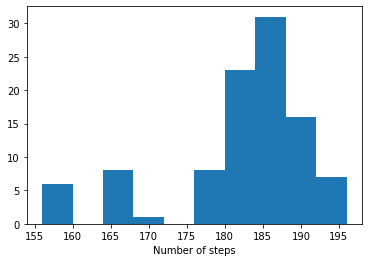

In [7]:
print("Testing performance")
test_performance = []
def policy(o, *_, **__):
    with torch.no_grad():
        return int(net(o).argmax())
for i in range(100):
    episode = list(run_env(policy, env=env))
    test_performance.append(len(episode))
print(test_performance)
plt.hist(test_performance)
plt.xlabel("Number of steps")